In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.stats.api as sms
from scipy.stats import (ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu,
                         pearsonr, spearmanr, kendalltau, f_oneway, kruskal)
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import MultiComparison
import zipfile, requests, io


In [3]:
# TODO : Import the Data from the kaggle API
url = 'https://github.com/devtlv/Datasets-DA-Bootcamp-2-/raw/refs/heads/main/Week%208%20-%20Hackathon%20&%20AB%20Testing/W8D3%20-%20AB%20Testing/AB_Test_Results.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.namelist()

# Load as pandas Dataframe
df = pd.read_csv(z.open('AB_Test_Results/AB_Test_Results.csv'))
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


# Data Understanding

In [4]:
#TODO : compute the following : DataFrame Information, Columns in DataFrame, Counting Missing Values, Descriptive Statistics, Value Counts for VARIANT_NAME, Counting Unique Users in USER_ID
# Info
print("--- INFO ---")
print(df.info())

# Number of Columns
print("\nNumber of Columns:", df.shape[1], '\n')

# Count Missing Values
print('Number of Missing Values:\n', df.isna().sum(), '\n')

# Descriptive Statistics
display(df['REVENUE'].describe())

# Value Counts for VARIANT_NAME
print(df['VARIANT_NAME'].value_counts())

# Unique User ID's
print("\nUnique Users:", df['USER_ID'].nunique())


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB
None

Number of Columns: 3 

Number of Missing Values:
 USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64 



count    10000.000000
mean         0.099447
std          2.318529
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        196.010000
Name: REVENUE, dtype: float64

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

Unique Users: 6324


In [5]:
print(df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts())

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64


# Average Revenue by VARIANT_NAME

In [6]:
#TODO
control_avg_rev = df[df['VARIANT_NAME'] == 'control']['REVENUE'].mean()
variant_avg_rev = df[df['VARIANT_NAME'] == 'variant']['REVENUE'].mean()

print(f"Control Avg. Reveue: {control_avg_rev:.4f}\nVariant Avg. Revenue: {variant_avg_rev:.4f}")

Control Avg. Reveue: 0.1290
Variant Avg. Revenue: 0.0701


What if H0: M1 = M2 ?
What about H1: M1 1= M2 ?

# Assumptions Control:
*# 1- Normality Assumptions*
*# 2- Homogeneity of Variances Assumption*

In [7]:
# TODO : test the normality of revenue data in two groups (variant and control) within your DataFrame df using the Shapiro-Wilk test, what can you conclude ?
# Separate the Groups Based on their Variant
df_control = df[df['VARIANT_NAME'] == 'control']
df_variant = df[df['VARIANT_NAME'] == 'variant']

# # Check Split
# print(df['VARIANT_NAME'].value_counts())
# print(df_control.shape[0], df_variant.shape[0])

# Test Normality of Control Group
stat, p = shapiro(df_control['REVENUE'])
print(f'Control W-statistic: {stat:.4f}')
print(f'Control p-value: {p:.4f}')

if p > 0.05:
    print("Fail to Reject N0, Dataset distribution is likely normal")
else:
    print("Reject N0, Dataset distribution is NOT normal")

Control W-statistic: 0.0183
Control p-value: 0.0000
Reject N0, Dataset distribution is NOT normal


In [8]:
# TODO : test for the homogeneity of variances between two groups (variant and control) within your DataFrame df using the Levene's test,  what can you conclude ?
stat, p = levene(df_control['REVENUE'], df_variant['REVENUE'], center='mean')

print(f"Statistic: {stat:.4f}, P-Value: {p:.4f}")
if p > 0.05:
    print("Fail to reject N0: Variances among test groups are homogeneous")
else:
    print("Reject N0: Variances among test groups are NOT homogeneous")

Statistic: 6.2915, P-Value: 0.0121
Reject N0: Variances among test groups are NOT homogeneous


# Non-Parametric Test (mannwhitneyu Test)

In [9]:
from sklearn.utils import resample
# TODO : perform the Mann-Whitney U test for comparing the average revenue between the variant and control groups in your DataFrame, what can you conclude ?
x = df_control['REVENUE'].values
y = df_variant['REVENUE'].values

stat, p = mannwhitneyu(x, y)

print(f"Control Samples: {len(x)}, Variant Samples: {len(y)}")
print(f"Mann-Whitney U Test: U={stat}, p-value={p}")

# Bootstrap method for difference in means
diffs = []
for _ in range(10000):
    sample_A = resample(x)
    sample_B = resample(y)
    diff = np.mean(sample_B) - np.mean(sample_A)
    diffs.append(diff)

confidence_interval = np.percentile(diffs, [2.5, 97.5])

if p > 0.05:
    print("Fail to reject N0, Distribution of Revenue for Control and Variant groups are most likely the same," \
    "\nthere is no tendency for values in one group to be higher than values in the other group.")
else:
    print("Reject the N0, Distribution of Revenue between test groups is NOT similar")
print(f"\n95% Confidence Interval for the difference in means: {confidence_interval}")

Control Samples: 4984, Variant Samples: 5016
Mann-Whitney U Test: U=12521564.0, p-value=0.47825247965294926
Fail to reject N0, Distribution of Revenue for Control and Variant groups are most likely the same,
there is no tendency for values in one group to be higher than values in the other group.

95% Confidence Interval for the difference in means: [-0.16439155  0.01841085]


The null hypothesis can be expressed as:

- **Most general**: The distributions of the two populations are identical
- **Practical interpretation**: There is no tendency for values in one group to be higher than values in the other group
- **In terms of medians (common simplification)**: The median of group A equals the median of group B

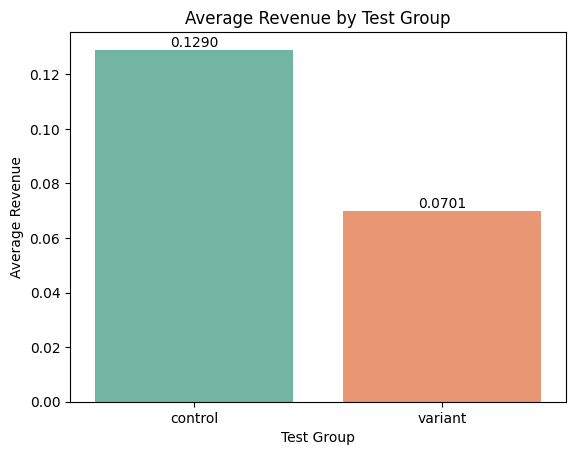

In [10]:
# TODO : create a bar plot showing the average revenues by variant names using the seaborn library
# Prepare Data for Barplot
data = df.groupby('VARIANT_NAME')['REVENUE'].mean().reset_index()

# Plot Using Seaborn
ax = sns.barplot(data, x='VARIANT_NAME', y='REVENUE', hue='VARIANT_NAME', legend=False, palette='Set2')

# Add labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')

plt.title("Average Revenue by Test Group")
plt.xlabel("Test Group")
plt.ylabel("Average Revenue")
plt.show()